In [1]:
import os
import sys
import cv2 as cv
from time import time
import pickle as pkl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["figure.figsize"] = (10,10)
from dask import delayed
from IPython.display import display

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

from skimage import img_as_ubyte, img_as_float, segmentation, color, exposure, img_as_uint
from skimage.io import imread, imsave
from skimage.future import graph
from skimage.filters import gaussian, sobel_v, threshold_otsu
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb
from skimage.exposure import equalize_hist
from skimage.transform import integral_image, rescale
from skimage.feature import haar_like_feature, hog, multiblock_lbp, local_binary_pattern
from skimage.measure import label

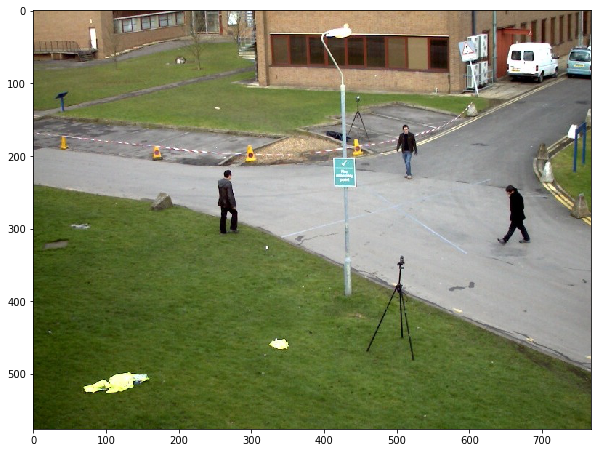

In [2]:
img = imread('../sequence/000001.jpg')
plt.imshow(img)

(576, 768, 3) (795, 1327104)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


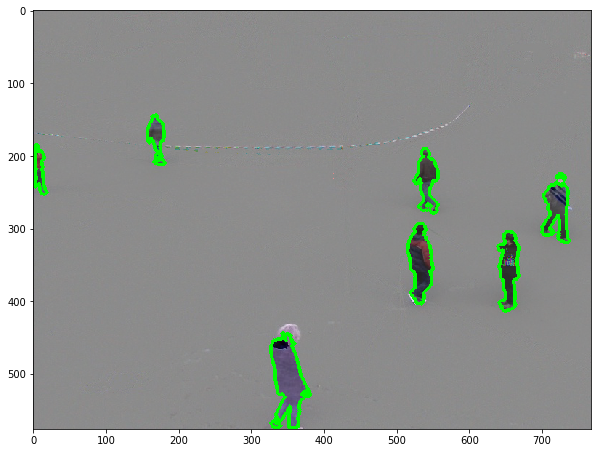

In [3]:
def getContours(img_array):
    gray = rgb2gray(img_array * 255).astype(np.uint8)
    gray_border = cv.rectangle(gray, (0,0), (gray.shape[1], gray.shape[0]), 255, 3)
    blur = cv.GaussianBlur(gray_border,(1,1),1000)
    flag, thresh = cv.threshold(blur, 120, 255, cv.THRESH_BINARY)
    contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv.contourArea,reverse=True) 
    perimeters = [cv.arcLength(contours[i],True) for i in range(len(contours))]
    listindex = [i for i in range(1, 15) if perimeters[i]>20]
    selected = [contours[i] for i in listindex]
    imgcont = img_array.copy()
    cv.drawContours(imgcont, selected, -1, (0, 255, 0), 3)
    return selected, imgcont

def removeBackgrounds(imgs_array):
    img_shape = imgs_array.shape[1:]
    imgs_array = imgs_array.reshape(imgs_array.shape[0], -1)
    print(img_shape, imgs_array.shape)
    imgs_modes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=imgs_array)
    
    outs = list()
    for img in imgs_array:
        sub = np.subtract(img, imgs_modes)
        sub = (sub - sub.min()) / (sub.max() - sub.min())
        conts, contimg = getContours(sub.reshape(img_shape))
        outs.append(contimg)
    return np.array(outs)
        
images = list()
for path, subdirs, files in os.walk('../sequence/'):
    for name in files:
        filename = os.path.join(path, name)
        images.append(imread(filename))
        
sub_images = removeBackgrounds(np.array(images))
plt.imshow(sub_images[0])

<IPython.core.display.Javascript object>


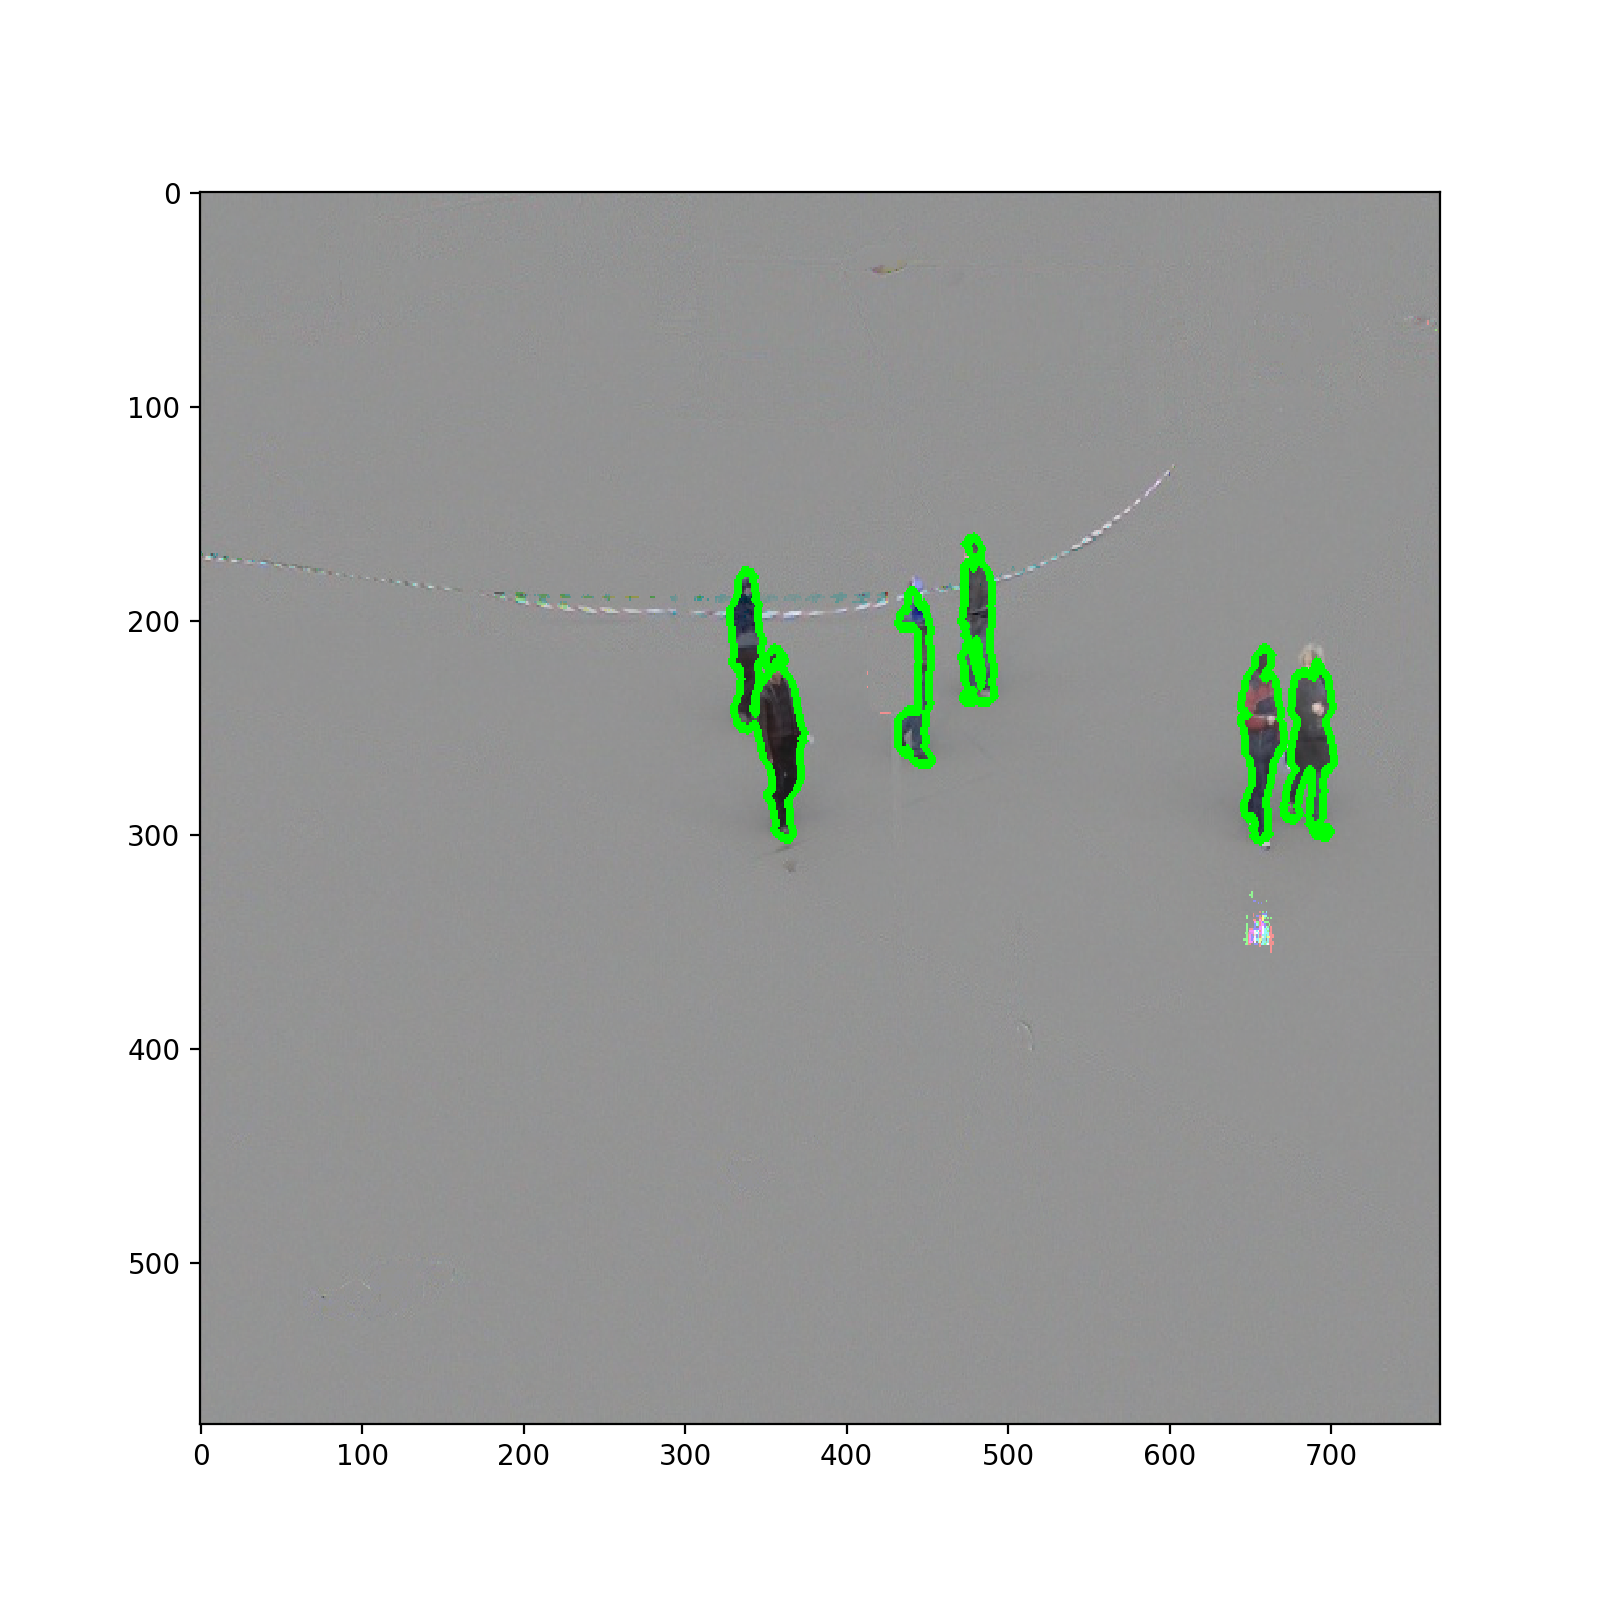

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [4]:
%matplotlib notebook
fps = 30
nSeconds = len(sub_images) // fps

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = sub_images[0]
im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(sub_images[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               )